In [3]:
import os
import re

import anndata
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

import mgitools.os_helpers as os_helpers

In [28]:
import pollock
from pollock.models.model import PollockDataset, PollockModel, load_from_directory

In [2]:
# !pip install git+https://github.com/estorrs/mgitools

In [73]:
from pathlib import Path
results_dir = os.path.join('/home/estorrs/pollock/results/cross_dataset_comparison_09082020')
Path(results_dir).mkdir(exist_ok=True, parents=True)

In [88]:
sc.settings.figdir = results_dir

In [ ]:
## load in datasets

In [5]:
fps = sorted(os_helpers.listfiles('/home/estorrs/data/single_cell_classification/tumor/', regex='.h5ad$'))
fps

['/home/estorrs/data/single_cell_classification/tumor/BR/raw/houxiang_brca/merged.h5ad',
 '/home/estorrs/data/single_cell_classification/tumor/BR/snATAC/merged.h5ad',
 '/home/estorrs/data/single_cell_classification/tumor/BR/snRNA/merged.h5ad',
 '/home/estorrs/data/single_cell_classification/tumor/CCRCC/yige/adata.h5ad',
 '/home/estorrs/data/single_cell_classification/tumor/CESC/cesc.h5ad',
 '/home/estorrs/data/single_cell_classification/tumor/HNSC/processed.h5ad',
 '/home/estorrs/data/single_cell_classification/tumor/PDAC/pdac.h5ad',
 '/home/estorrs/data/single_cell_classification/tumor/PDAC/pdac_caf_subtypes.h5ad',
 '/home/estorrs/data/single_cell_classification/tumor/aml/aml.h5ad',
 '/home/estorrs/data/single_cell_classification/tumor/gbm/gbm.h5ad',
 '/home/estorrs/data/single_cell_classification/tumor/master/master.h5ad',
 '/home/estorrs/data/single_cell_classification/tumor/melanoma/melanoma.h5ad',
 '/home/estorrs/data/single_cell_classification/tumor/melanoma/melanoma_hugo.h5ad',


In [6]:
fps = sorted(os_helpers.listfiles('/home/estorrs/data/single_cell_classification/immune/', regex='.h5ad$'))
fps

['/home/estorrs/data/single_cell_classification/immune/snCCRCC/merged.h5ad']

In [24]:
fp_map = {
    'scRNA': {
        'BRCA': '/home/estorrs/data/single_cell_classification/tumor/BR/raw/houxiang_brca/merged.h5ad',
        'CESC': '/home/estorrs/data/single_cell_classification/tumor/CESC/cesc.h5ad',
        'HNSCC': '/home/estorrs/data/single_cell_classification/tumor/HNSC/processed.h5ad',
        'PDAC': '/home/estorrs/data/single_cell_classification/tumor/PDAC/pdac.h5ad',
#         'AML': '/home/estorrs/data/single_cell_classification/tumor/aml/aml.h5ad',
        'Melanoma': '/home/estorrs/data/single_cell_classification/tumor/melanoma/melanoma_hugo.h5ad',
        'MMY': '/home/estorrs/data/single_cell_classification/tumor/myeloma/reyka_07082020.h5ad',
        'PBMC3K': '/home/estorrs/data/single_cell_classification/tumor/pbmc/pbmc3k.h5ad'
  
    },
    'snRNA': {
#         'BRCA': '/home/estorrs/data/single_cell_classification/tumor/BR/snRNA/merged.h5ad',
        'CCRCC': '/home/estorrs/data/single_cell_classification/tumor/CCRCC/yige/adata.h5ad',
        'CCRCC_immune': '/home/estorrs/data/single_cell_classification/immune/snCCRCC/merged.h5ad',
        'GBM': '/home/estorrs/data/single_cell_classification/tumor/gbm/gbm.h5ad',        
        
    },
#     'snATAC': {
#         'BRCA': '/home/estorrs/data/single_cell_classification/tumor/BR/snATAC/merged.h5ad',
#     }
}

In [25]:
for cat, d in fp_map.items():
    for cancer, fp in d.items():
        print(cat, cancer)
        adata = sc.read_h5ad(fp)
        print(adata.shape, 'cell_type' in adata.obs.columns)

scRNA BRCA
(48280, 33538) True
scRNA CESC
(31745, 33751) True
scRNA HNSCC
(60001, 33751) True
scRNA PDAC
(65141, 27160) True
scRNA Melanoma
(27282, 32705) True
scRNA MMY
(32118, 20976) True
scRNA PBMC3K
(2638, 32738) True
snRNA CCRCC
(130429, 32798) True
snRNA CCRCC_immune
(134019, 33538) True
snRNA GBM
(111979, 29032) True


In [30]:
modules = [os.path.join('/home/estorrs/pollock/models/modules/', fp)
    for fp in sorted(os.listdir('/home/estorrs/pollock/models/modules/'))]
modules

['/home/estorrs/pollock/models/modules/br_v0.1.0',
 '/home/estorrs/pollock/models/modules/ccrcc_v0.1.0',
 '/home/estorrs/pollock/models/modules/cesc_v0.1.0',
 '/home/estorrs/pollock/models/modules/gbm_v0.1.0',
 '/home/estorrs/pollock/models/modules/hnscc_v0.1.0',
 '/home/estorrs/pollock/models/modules/melanoma_v0.1.0',
 '/home/estorrs/pollock/models/modules/myeloma_v0.1.0',
 '/home/estorrs/pollock/models/modules/pbmc3k_v0.1.0',
 '/home/estorrs/pollock/models/modules/pdac_caf_filtered_v0.1.0',
 '/home/estorrs/pollock/models/modules/pdac_caf_v0.1.0',
 '/home/estorrs/pollock/models/modules/pdac_v0.1.0',
 '/home/estorrs/pollock/models/modules/sc_tier_1_v0.1.0',
 '/home/estorrs/pollock/models/modules/sc_tier_2_v0.1.0',
 '/home/estorrs/pollock/models/modules/snCCRCC_alla_v0.1.0',
 '/home/estorrs/pollock/models/modules/zheng_sorted_v0.1.0']

## run modules

In [40]:
def run_basic_preprocessing(adata):
    sc.pp.filter_genes(adata, min_cells=3)

    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

#     adata = adata[adata.obs.n_genes_by_counts < 2500, :]
#     adata = adata[adata.obs.pct_counts_mt < 5, :]

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata)

    adata.raw = adata
    
    adata = adata[:, adata.var.highly_variable]

    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

    sc.pp.scale(adata)
    
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)
    
    return adata

def predict_adata(adata, module):
    ## create raw counts layer
#     adata.layers['raw_counts'] = adata.X.copy()
#     prediction_adata = anndata.AnnData(X=adata.layers['raw_counts'].copy(),
#                                       obs=adata.obs, var=adata.var)
    
    ## create pollock model and dataset
    loaded_pds, loaded_pm = load_from_directory(prediction_adata, module)
    
    ## predict
    labels, probs, cell_type_probs = loaded_pm.predict_pollock_dataset(loaded_pds, labels=True, )

    ## merge back into adata
    df = pd.DataFrame.from_dict({
        'predicted_cell_type': labels,
        'cell_type_probability': probs,
    })
    df.index = prediction_adata.obs.index
    df = pd.concat((df, pd.DataFrame(data=cell_type_probs, index=prediction_adata.obs.index,
                                columns=[f'probability_{c}' for c in loaded_pds.cell_types])), axis=1)
    return df



In [41]:
cancer_to_module_predictions = {}
cancer_to_adata = {}
for cancer, fp in fp_map['scRNA'].items():
    adata = sc.read_h5ad(fp)
    prediction_adata = adata.copy()
    adata.layers['raw_counts'] = adata.X.copy()
    adata = run_basic_preprocessing(adata)
    cancer_to_module_predictions[cancer] = {}
    cancer_to_adata[cancer] = adata
    for module in modules:
        name = module.split('/')[-1]
        print(cancer, name)
        predictions = predict_adata(prediction_adata, module)
        cancer_to_module_predictions[cancer][name] = predictions
        
        

/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
2020-09-08 11:32:53,229 normalizing counts for prediction
2020-09-08 11:32:53,231 filtering for genes in training set
2020-09-08 11:32:53,241 0 genes in training set are missing from prediction set


BRCA br_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:33:23,177 scaling data


BRCA ccrcc_v0.1.0


2020-09-08 11:33:51,297 normalizing counts for prediction
2020-09-08 11:33:51,298 filtering for genes in training set
2020-09-08 11:33:51,312 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:34:20,428 scaling data


BRCA cesc_v0.1.0


2020-09-08 11:34:47,738 normalizing counts for prediction
2020-09-08 11:34:47,739 filtering for genes in training set
2020-09-08 11:34:47,752 213 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:35:17,869 scaling data


BRCA gbm_v0.1.0


2020-09-08 11:35:46,191 normalizing counts for prediction
2020-09-08 11:35:46,192 filtering for genes in training set
2020-09-08 11:35:46,202 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:36:12,545 scaling data
2020-09-08 11:36:35,316 normalizing counts for prediction
2020-09-08 11:36:35,317 filtering for genes in training set
2020-09-08 11:36:35,327 213 genes in training set are missing from prediction set


BRCA hnscc_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:37:05,466 scaling data
2020-09-08 11:37:34,118 normalizing counts for prediction
2020-09-08 11:37:34,119 filtering for genes in training set
2020-09-08 11:37:34,133 33538 genes in training set are missing from prediction set


BRCA melanoma_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:38:22,779 scaling data


BRCA myeloma_v0.1.0


2020-09-08 11:38:48,410 normalizing counts for prediction
2020-09-08 11:38:48,411 filtering for genes in training set
2020-09-08 11:38:48,419 4343 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:39:17,191 scaling data
2020-09-08 11:39:36,163 normalizing counts for prediction
2020-09-08 11:39:36,164 filtering for genes in training set
2020-09-08 11:39:36,169 158 genes in training set are missing from prediction set


BRCA pbmc3k_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:39:44,032 scaling data


BRCA pdac_caf_filtered_v0.1.0


2020-09-08 11:39:46,814 normalizing counts for prediction
2020-09-08 11:39:46,815 filtering for genes in training set
2020-09-08 11:39:46,826 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:40:11,334 scaling data
2020-09-08 11:40:29,745 normalizing counts for prediction
2020-09-08 11:40:29,745 filtering for genes in training set
2020-09-08 11:40:29,755 0 genes in training set are missing from prediction set


BRCA pdac_caf_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:40:53,697 scaling data
2020-09-08 11:41:13,973 normalizing counts for prediction
2020-09-08 11:41:13,974 filtering for genes in training set
2020-09-08 11:41:13,984 0 genes in training set are missing from prediction set


BRCA pdac_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:41:38,964 scaling data


BRCA sc_tier_1_v0.1.0


2020-09-08 11:42:01,078 normalizing counts for prediction
2020-09-08 11:42:01,079 filtering for genes in training set
2020-09-08 11:42:01,086 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:42:16,552 scaling data


BRCA sc_tier_2_v0.1.0


2020-09-08 11:42:28,939 normalizing counts for prediction
2020-09-08 11:42:28,940 filtering for genes in training set
2020-09-08 11:42:28,947 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:42:44,208 scaling data


BRCA snCCRCC_alla_v0.1.0


2020-09-08 11:42:55,665 normalizing counts for prediction
2020-09-08 11:42:55,666 filtering for genes in training set
2020-09-08 11:42:55,676 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:43:25,213 scaling data
2020-09-08 11:43:50,858 normalizing counts for prediction
2020-09-08 11:43:50,859 filtering for genes in training set
2020-09-08 11:43:50,869 6304 genes in training set are missing from prediction set


BRCA zheng_sorted_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:44:16,545 scaling data
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
2020-09-08 11:46:46,248 normalizing counts for prediction
2020-09-08 11:46:46,249 filtering for genes in training set
2020-09-08 11:46:46,262 0 genes in training set are missing from prediction set


CESC br_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:47:05,477 scaling data


CESC ccrcc_v0.1.0


2020-09-08 11:47:23,488 normalizing counts for prediction
2020-09-08 11:47:23,489 filtering for genes in training set
2020-09-08 11:47:23,502 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:47:42,501 scaling data
2020-09-08 11:48:00,552 normalizing counts for prediction
2020-09-08 11:48:00,552 filtering for genes in training set
2020-09-08 11:48:00,566 0 genes in training set are missing from prediction set


CESC cesc_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:48:20,220 scaling data


CESC gbm_v0.1.0


2020-09-08 11:48:38,948 normalizing counts for prediction
2020-09-08 11:48:38,949 filtering for genes in training set
2020-09-08 11:48:38,960 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:48:56,260 scaling data
2020-09-08 11:49:11,341 normalizing counts for prediction
2020-09-08 11:49:11,341 filtering for genes in training set
2020-09-08 11:49:11,355 0 genes in training set are missing from prediction set


CESC hnscc_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:49:31,003 scaling data


CESC melanoma_v0.1.0


2020-09-08 11:49:50,245 normalizing counts for prediction
2020-09-08 11:49:50,246 filtering for genes in training set
2020-09-08 11:49:50,260 33538 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:50:21,707 scaling data


CESC myeloma_v0.1.0


2020-09-08 11:50:39,194 normalizing counts for prediction
2020-09-08 11:50:39,195 filtering for genes in training set
2020-09-08 11:50:39,205 4343 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:50:57,938 scaling data
2020-09-08 11:51:10,729 normalizing counts for prediction
2020-09-08 11:51:10,730 filtering for genes in training set
2020-09-08 11:51:10,735 158 genes in training set are missing from prediction set


CESC pbmc3k_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:51:15,871 scaling data
2020-09-08 11:51:17,591 normalizing counts for prediction
2020-09-08 11:51:17,592 filtering for genes in training set
2020-09-08 11:51:17,606 0 genes in training set are missing from prediction set


CESC pdac_caf_filtered_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:51:33,628 scaling data


CESC pdac_caf_v0.1.0


2020-09-08 11:51:47,458 normalizing counts for prediction
2020-09-08 11:51:47,459 filtering for genes in training set
2020-09-08 11:51:47,469 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:52:02,917 scaling data
2020-09-08 11:52:15,987 normalizing counts for prediction
2020-09-08 11:52:15,988 filtering for genes in training set
2020-09-08 11:52:15,998 0 genes in training set are missing from prediction set


CESC pdac_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:52:32,319 scaling data


CESC sc_tier_1_v0.1.0


2020-09-08 11:52:47,485 normalizing counts for prediction
2020-09-08 11:52:47,487 filtering for genes in training set
2020-09-08 11:52:47,495 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:52:58,206 scaling data


CESC sc_tier_2_v0.1.0


2020-09-08 11:53:06,784 normalizing counts for prediction
2020-09-08 11:53:06,785 filtering for genes in training set
2020-09-08 11:53:06,793 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:53:17,643 scaling data


CESC snCCRCC_alla_v0.1.0


2020-09-08 11:53:25,740 normalizing counts for prediction
2020-09-08 11:53:25,742 filtering for genes in training set
2020-09-08 11:53:25,753 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:53:44,647 scaling data
2020-09-08 11:54:02,245 normalizing counts for prediction
2020-09-08 11:54:02,247 filtering for genes in training set
2020-09-08 11:54:02,261 6304 genes in training set are missing from prediction set


CESC zheng_sorted_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:54:19,383 scaling data
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


HNSCC br_v0.1.0


2020-09-08 11:58:55,095 normalizing counts for prediction
2020-09-08 11:58:55,096 filtering for genes in training set
2020-09-08 11:58:55,109 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 11:59:32,987 scaling data


HNSCC ccrcc_v0.1.0


2020-09-08 12:00:07,952 normalizing counts for prediction
2020-09-08 12:00:07,953 filtering for genes in training set
2020-09-08 12:00:07,967 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:00:45,041 scaling data
2020-09-08 12:01:18,971 normalizing counts for prediction
2020-09-08 12:01:18,972 filtering for genes in training set
2020-09-08 12:01:18,984 0 genes in training set are missing from prediction set


HNSCC cesc_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:01:57,364 scaling data


HNSCC gbm_v0.1.0


2020-09-08 12:02:40,537 normalizing counts for prediction
2020-09-08 12:02:40,538 filtering for genes in training set
2020-09-08 12:02:40,552 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:03:14,324 scaling data
2020-09-08 12:03:42,480 normalizing counts for prediction
2020-09-08 12:03:42,481 filtering for genes in training set
2020-09-08 12:03:42,502 0 genes in training set are missing from prediction set


HNSCC hnscc_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:04:20,681 scaling data
2020-09-08 12:05:03,089 normalizing counts for prediction
2020-09-08 12:05:03,090 filtering for genes in training set
2020-09-08 12:05:03,105 33538 genes in training set are missing from prediction set


HNSCC melanoma_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:06:19,247 scaling data


HNSCC myeloma_v0.1.0


2020-09-08 12:06:52,682 normalizing counts for prediction
2020-09-08 12:06:52,683 filtering for genes in training set
2020-09-08 12:06:52,693 4343 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:07:29,321 scaling data
2020-09-08 12:07:52,556 normalizing counts for prediction
2020-09-08 12:07:52,556 filtering for genes in training set
2020-09-08 12:07:52,562 158 genes in training set are missing from prediction set


HNSCC pbmc3k_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:08:02,310 scaling data
2020-09-08 12:08:05,683 normalizing counts for prediction
2020-09-08 12:08:05,684 filtering for genes in training set
2020-09-08 12:08:05,699 0 genes in training set are missing from prediction set


HNSCC pdac_caf_filtered_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:08:36,436 scaling data
2020-09-08 12:08:59,942 normalizing counts for prediction
2020-09-08 12:08:59,943 filtering for genes in training set
2020-09-08 12:08:59,954 0 genes in training set are missing from prediction set


HNSCC pdac_caf_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:09:31,028 scaling data
2020-09-08 12:09:55,026 normalizing counts for prediction
2020-09-08 12:09:55,027 filtering for genes in training set
2020-09-08 12:09:55,038 0 genes in training set are missing from prediction set


HNSCC pdac_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:10:27,851 scaling data


HNSCC sc_tier_1_v0.1.0


2020-09-08 12:10:56,213 normalizing counts for prediction
2020-09-08 12:10:56,214 filtering for genes in training set
2020-09-08 12:10:56,223 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:11:16,395 scaling data


HNSCC sc_tier_2_v0.1.0


2020-09-08 12:11:30,891 normalizing counts for prediction
2020-09-08 12:11:30,892 filtering for genes in training set
2020-09-08 12:11:30,902 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:11:51,279 scaling data


HNSCC snCCRCC_alla_v0.1.0


2020-09-08 12:12:05,536 normalizing counts for prediction
2020-09-08 12:12:05,537 filtering for genes in training set
2020-09-08 12:12:05,550 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:12:42,688 scaling data
2020-09-08 12:13:16,690 normalizing counts for prediction
2020-09-08 12:13:16,691 filtering for genes in training set
2020-09-08 12:13:16,703 6304 genes in training set are missing from prediction set


HNSCC zheng_sorted_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:13:49,663 scaling data
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


PDAC br_v0.1.0


2020-09-08 12:17:46,276 normalizing counts for prediction
2020-09-08 12:17:46,277 filtering for genes in training set
2020-09-08 12:17:46,289 6378 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:17:52,570 scaling data


PDAC ccrcc_v0.1.0


2020-09-08 12:18:24,367 normalizing counts for prediction
2020-09-08 12:18:24,368 filtering for genes in training set
2020-09-08 12:18:24,381 6085 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:18:30,580 scaling data


PDAC cesc_v0.1.0


2020-09-08 12:19:00,911 normalizing counts for prediction
2020-09-08 12:19:00,912 filtering for genes in training set
2020-09-08 12:19:00,925 6591 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:19:07,127 scaling data


PDAC gbm_v0.1.0


2020-09-08 12:19:38,469 normalizing counts for prediction
2020-09-08 12:19:38,470 filtering for genes in training set
2020-09-08 12:19:38,482 3709 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:19:44,838 scaling data


PDAC hnscc_v0.1.0


2020-09-08 12:20:12,107 normalizing counts for prediction
2020-09-08 12:20:12,108 filtering for genes in training set
2020-09-08 12:20:12,121 6591 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:20:18,411 scaling data
2020-09-08 12:20:49,432 normalizing counts for prediction
2020-09-08 12:20:49,433 filtering for genes in training set
2020-09-08 12:20:49,447 33538 genes in training set are missing from prediction set


PDAC melanoma_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:20:53,521 scaling data
2020-09-08 12:21:19,108 normalizing counts for prediction
2020-09-08 12:21:19,109 filtering for genes in training set
2020-09-08 12:21:19,119 4555 genes in training set are missing from prediction set


PDAC myeloma_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:21:25,472 scaling data
2020-09-08 12:21:48,588 normalizing counts for prediction
2020-09-08 12:21:48,589 filtering for genes in training set
2020-09-08 12:21:48,595 161 genes in training set are missing from prediction set


PDAC pbmc3k_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:21:53,055 scaling data
2020-09-08 12:21:56,288 normalizing counts for prediction
2020-09-08 12:21:56,289 filtering for genes in training set
2020-09-08 12:21:56,300 210 genes in training set are missing from prediction set


PDAC pdac_caf_filtered_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:22:02,609 scaling data
2020-09-08 12:22:26,532 normalizing counts for prediction
2020-09-08 12:22:26,532 filtering for genes in training set
2020-09-08 12:22:26,545 210 genes in training set are missing from prediction set


PDAC pdac_caf_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:22:32,929 scaling data


PDAC pdac_v0.1.0


2020-09-08 12:22:55,551 normalizing counts for prediction
2020-09-08 12:22:55,552 filtering for genes in training set
2020-09-08 12:22:55,564 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:23:01,927 scaling data


PDAC sc_tier_1_v0.1.0


2020-09-08 12:23:28,401 normalizing counts for prediction
2020-09-08 12:23:28,402 filtering for genes in training set
2020-09-08 12:23:28,411 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:23:34,622 scaling data


PDAC sc_tier_2_v0.1.0


2020-09-08 12:23:49,811 normalizing counts for prediction
2020-09-08 12:23:49,812 filtering for genes in training set
2020-09-08 12:23:49,822 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:23:55,966 scaling data


PDAC snCCRCC_alla_v0.1.0


2020-09-08 12:24:10,934 normalizing counts for prediction
2020-09-08 12:24:10,935 filtering for genes in training set
2020-09-08 12:24:10,949 6378 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:24:17,256 scaling data
2020-09-08 12:24:48,292 normalizing counts for prediction
2020-09-08 12:24:48,293 filtering for genes in training set
2020-09-08 12:24:48,303 6465 genes in training set are missing from prediction set


PDAC zheng_sorted_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:24:54,412 scaling data
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
2020-09-08 12:27:14,314 normalizing counts for prediction
2020-09-08 12:27:14,315 filtering for genes in training set
2020-09-08 12:27:14,329 2516 genes in training set are missing from prediction set


Melanoma br_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:27:36,231 scaling data


Melanoma ccrcc_v0.1.0


2020-09-08 12:27:52,392 normalizing counts for prediction
2020-09-08 12:27:52,393 filtering for genes in training set
2020-09-08 12:27:52,407 1900 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:28:13,783 scaling data


Melanoma cesc_v0.1.0


2020-09-08 12:28:29,278 normalizing counts for prediction
2020-09-08 12:28:29,278 filtering for genes in training set
2020-09-08 12:28:29,292 2729 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:28:51,270 scaling data


Melanoma gbm_v0.1.0


2020-09-08 12:29:07,663 normalizing counts for prediction
2020-09-08 12:29:07,664 filtering for genes in training set
2020-09-08 12:29:07,676 2053 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:29:27,317 scaling data
2020-09-08 12:29:40,529 normalizing counts for prediction
2020-09-08 12:29:40,529 filtering for genes in training set
2020-09-08 12:29:40,542 2729 genes in training set are missing from prediction set


Melanoma hnscc_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:30:02,701 scaling data
2020-09-08 12:30:18,876 normalizing counts for prediction
2020-09-08 12:30:18,877 filtering for genes in training set
2020-09-08 12:30:18,892 33538 genes in training set are missing from prediction set


Melanoma melanoma_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:30:46,161 scaling data
2020-09-08 12:31:01,600 normalizing counts for prediction
2020-09-08 12:31:01,601 filtering for genes in training set
2020-09-08 12:31:01,613 5265 genes in training set are missing from prediction set


Melanoma myeloma_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:31:19,549 scaling data
2020-09-08 12:31:30,484 normalizing counts for prediction
2020-09-08 12:31:30,485 filtering for genes in training set
2020-09-08 12:31:30,491 191 genes in training set are missing from prediction set


Melanoma pbmc3k_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:31:34,952 scaling data
2020-09-08 12:31:36,855 normalizing counts for prediction
2020-09-08 12:31:36,856 filtering for genes in training set
2020-09-08 12:31:36,871 1574 genes in training set are missing from prediction set


Melanoma pdac_caf_filtered_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:31:54,605 scaling data
2020-09-08 12:32:06,244 normalizing counts for prediction
2020-09-08 12:32:06,245 filtering for genes in training set
2020-09-08 12:32:06,262 1574 genes in training set are missing from prediction set


Melanoma pdac_caf_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:32:23,948 scaling data


Melanoma pdac_v0.1.0


2020-09-08 12:32:35,953 normalizing counts for prediction
2020-09-08 12:32:35,955 filtering for genes in training set
2020-09-08 12:32:35,968 1752 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:32:54,624 scaling data


Melanoma sc_tier_1_v0.1.0


2020-09-08 12:33:07,364 normalizing counts for prediction
2020-09-08 12:33:07,364 filtering for genes in training set
2020-09-08 12:33:07,372 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:33:18,426 scaling data


Melanoma sc_tier_2_v0.1.0


2020-09-08 12:33:25,927 normalizing counts for prediction
2020-09-08 12:33:25,928 filtering for genes in training set
2020-09-08 12:33:25,937 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:33:36,899 scaling data


Melanoma snCCRCC_alla_v0.1.0


2020-09-08 12:33:43,887 normalizing counts for prediction
2020-09-08 12:33:43,888 filtering for genes in training set
2020-09-08 12:33:43,904 2516 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:34:05,686 scaling data
2020-09-08 12:34:20,709 normalizing counts for prediction
2020-09-08 12:34:20,709 filtering for genes in training set
2020-09-08 12:34:20,722 6681 genes in training set are missing from prediction set


Melanoma zheng_sorted_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:34:37,563 scaling data
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
2020-0

MMY br_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:36:24,621 scaling data


MMY ccrcc_v0.1.0


2020-09-08 12:36:40,195 normalizing counts for prediction
2020-09-08 12:36:40,196 filtering for genes in training set
2020-09-08 12:36:40,210 12091 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:36:42,310 scaling data


MMY cesc_v0.1.0


2020-09-08 12:36:57,528 normalizing counts for prediction
2020-09-08 12:36:57,528 filtering for genes in training set
2020-09-08 12:36:57,543 12775 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:36:59,744 scaling data


MMY gbm_v0.1.0


2020-09-08 12:37:15,406 normalizing counts for prediction
2020-09-08 12:37:15,407 filtering for genes in training set
2020-09-08 12:37:15,418 8994 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:37:17,556 scaling data
2020-09-08 12:37:30,674 normalizing counts for prediction
2020-09-08 12:37:30,675 filtering for genes in training set
2020-09-08 12:37:30,688 12775 genes in training set are missing from prediction set


MMY hnscc_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:37:32,782 scaling data
2020-09-08 12:37:47,792 normalizing counts for prediction
2020-09-08 12:37:47,793 filtering for genes in training set
2020-09-08 12:37:47,807 33538 genes in training set are missing from prediction set


MMY melanoma_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:37:49,182 scaling data
2020-09-08 12:38:02,228 normalizing counts for prediction
2020-09-08 12:38:02,229 filtering for genes in training set
2020-09-08 12:38:02,240 5220 genes in training set are missing from prediction set


MMY myeloma_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:38:04,309 scaling data
2020-09-08 12:38:15,539 normalizing counts for prediction
2020-09-08 12:38:15,540 filtering for genes in training set
2020-09-08 12:38:15,545 162 genes in training set are missing from prediction set


MMY pbmc3k_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:38:17,088 scaling data
2020-09-08 12:38:18,885 normalizing counts for prediction
2020-09-08 12:38:18,886 filtering for genes in training set
2020-09-08 12:38:18,905 4938 genes in training set are missing from prediction set


MMY pdac_caf_filtered_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:38:21,158 scaling data


MMY pdac_caf_v0.1.0


2020-09-08 12:38:33,257 normalizing counts for prediction
2020-09-08 12:38:33,258 filtering for genes in training set
2020-09-08 12:38:33,268 4938 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:38:35,392 scaling data
2020-09-08 12:38:47,151 normalizing counts for prediction
2020-09-08 12:38:47,151 filtering for genes in training set
2020-09-08 12:38:47,162 6334 genes in training set are missing from prediction set


MMY pdac_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:38:49,231 scaling data


MMY sc_tier_1_v0.1.0


2020-09-08 12:39:02,776 normalizing counts for prediction
2020-09-08 12:39:02,777 filtering for genes in training set
2020-09-08 12:39:02,784 232 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:39:04,863 scaling data


MMY sc_tier_2_v0.1.0


2020-09-08 12:39:12,764 normalizing counts for prediction
2020-09-08 12:39:12,765 filtering for genes in training set
2020-09-08 12:39:12,774 232 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:39:14,768 scaling data


MMY snCCRCC_alla_v0.1.0


2020-09-08 12:39:22,789 normalizing counts for prediction
2020-09-08 12:39:22,790 filtering for genes in training set
2020-09-08 12:39:22,802 12562 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:39:24,873 scaling data
2020-09-08 12:39:40,293 normalizing counts for prediction
2020-09-08 12:39:40,294 filtering for genes in training set
2020-09-08 12:39:40,304 7340 genes in training set are missing from prediction set


MMY zheng_sorted_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:39:42,375 scaling data
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/

PBMC3K br_v0.1.0


2020-09-08 12:40:05,433 normalizing counts for prediction
2020-09-08 12:40:05,434 filtering for genes in training set
2020-09-08 12:40:05,445 13085 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:40:05,589 scaling data


PBMC3K ccrcc_v0.1.0


2020-09-08 12:40:07,787 normalizing counts for prediction
2020-09-08 12:40:07,788 filtering for genes in training set
2020-09-08 12:40:07,799 12383 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:40:07,944 scaling data
2020-09-08 12:40:09,683 normalizing counts for prediction
2020-09-08 12:40:09,684 filtering for genes in training set
2020-09-08 12:40:09,697 13298 genes in training set are missing from prediction set


PBMC3K cesc_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:40:09,896 scaling data


PBMC3K gbm_v0.1.0


2020-09-08 12:40:12,056 normalizing counts for prediction
2020-09-08 12:40:12,056 filtering for genes in training set
2020-09-08 12:40:12,069 10326 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:40:12,235 scaling data
2020-09-08 12:40:13,778 normalizing counts for prediction
2020-09-08 12:40:13,778 filtering for genes in training set
2020-09-08 12:40:13,791 13298 genes in training set are missing from prediction set


PBMC3K hnscc_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:40:13,936 scaling data
2020-09-08 12:40:15,667 normalizing counts for prediction
2020-09-08 12:40:15,668 filtering for genes in training set
2020-09-08 12:40:15,682 33538 genes in training set are missing from prediction set


PBMC3K melanoma_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:40:15,852 scaling data


PBMC3K myeloma_v0.1.0


2020-09-08 12:40:17,754 normalizing counts for prediction
2020-09-08 12:40:17,754 filtering for genes in training set
2020-09-08 12:40:17,763 4607 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:40:17,896 scaling data
2020-09-08 12:40:19,132 normalizing counts for prediction
2020-09-08 12:40:19,133 filtering for genes in training set
2020-09-08 12:40:19,138 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_c

PBMC3K pbmc3k_v0.1.0


2020-09-08 12:40:19,600 normalizing counts for prediction
2020-09-08 12:40:19,601 filtering for genes in training set
2020-09-08 12:40:19,614 7457 genes in training set are missing from prediction set


PBMC3K pdac_caf_filtered_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:40:19,816 scaling data
2020-09-08 12:40:21,291 normalizing counts for prediction
2020-09-08 12:40:21,291 filtering for genes in training set
2020-09-08 12:40:21,303 7457 genes in training set are missing from prediction set


PBMC3K pdac_caf_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:40:21,509 scaling data


PBMC3K pdac_v0.1.0


2020-09-08 12:40:23,168 normalizing counts for prediction
2020-09-08 12:40:23,169 filtering for genes in training set
2020-09-08 12:40:23,179 8663 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:40:23,323 scaling data


PBMC3K sc_tier_1_v0.1.0


2020-09-08 12:40:25,447 normalizing counts for prediction
2020-09-08 12:40:25,448 filtering for genes in training set
2020-09-08 12:40:25,457 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:40:25,583 scaling data


PBMC3K sc_tier_2_v0.1.0


2020-09-08 12:40:28,095 normalizing counts for prediction
2020-09-08 12:40:28,096 filtering for genes in training set
2020-09-08 12:40:28,103 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:40:28,231 scaling data


PBMC3K snCCRCC_alla_v0.1.0


2020-09-08 12:40:29,652 normalizing counts for prediction
2020-09-08 12:40:29,653 filtering for genes in training set
2020-09-08 12:40:29,665 13085 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:40:29,809 scaling data
2020-09-08 12:40:31,626 normalizing counts for prediction
2020-09-08 12:40:31,627 filtering for genes in training set
2020-09-08 12:40:31,638 4780 genes in training set are missing from prediction set


PBMC3K zheng_sorted_v0.1.0


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-08 12:40:31,815 scaling data


In [43]:
cell_types = set()
for cancer, d in cancer_to_module_predictions.items():
    for module_name, preds in d.items():
        cell_types.update(preds['predicted_cell_type'])
        
for cancer, adata in cancer_to_adata.items():
    cell_types.update(adata.obs['cell_type'])

sorted(cell_types)

['Acinar',
 'Ascending Loop of Henle',
 'B',
 'B-cell',
 'B-cells',
 'BM4_Unknown',
 'BM5_Unknown',
 'BR_Malignant',
 'Basophils',
 'Bcell',
 'CAF',
 'CD133+_iCAF',
 'CD14 Monocytes',
 'CD14+ Monocyte',
 'CD14+Mono',
 'CD16+Mono',
 'CD19+ B',
 'CD34+',
 'CD4 CTL',
 'CD4 T',
 'CD4 T-cell',
 'CD4 T-cells',
 'CD4+ T Helper2',
 'CD4+ T-cells',
 'CD4+/CD25 T Reg',
 'CD4+/CD45RA+/CD25- Naive T',
 'CD4+/CD45RO+ Memory',
 'CD4+T',
 'CD4/CD8 T-cells',
 'CD4/CD8 proliferating',
 'CD4_T',
 'CD56+ NK',
 'CD8 CTL exhausted',
 'CD8 T',
 'CD8 T-cell',
 'CD8+ Cytotoxic T',
 'CD8+ T-cells',
 'CD8+/CD45RA+ Naive Cytotoxic',
 'CD8+T',
 'CD8_T',
 'CXCL4+_iCAF',
 'DC',
 'Dendritic',
 'Ductal',
 'Eccrine sweet glands',
 'Eccrine_sweet_glands',
 'Endothelial',
 'Endothelial cells',
 'Epithelial',
 'Erythrocyte',
 'FCGR3A Monocytes',
 'Fibroblast',
 'Fibroblasts',
 'HNSC_Malignant/Epithelial',
 'HPC',
 'Immature_Neutrophils',
 'Immune',
 'Keratinocyte',
 'MM',
 'Macrophage',
 'Macrophage/Monocyte',
 'Macropha

In [46]:
def is_malignant(ct,):
    if ct in ['BR_Malignant',
              'Ductal',
              'HNSC_Malignant'
              'Malignant',
              'Malignant proximal tubule',
              'Malignant_Epithelial',
              'Melanoma',
              'Tumor',
              'Tumor cells'
             ]:
        return True
#     if ct in ['Plasma',
#              'Plasma cells'] and cancer == 'MMY': return True
    return False

cell_type_map = {}
# cell_type_map.update({k:'Acinar' for k in cell_types if 'cinar' in k})
cell_type_map.update({k:'B-cell' for k in cell_types if 'B-cell' in k or k=='B' or 'Bcell' in k})
# cell_type_map.update({k:'Basophil' for k in cell_types if 'Basophil' in k or 'basophil' in k})
cell_type_map.update({k:'Fibroblast' for k in cell_types if 'ibroblast' in k or 'CAF' in k})
cell_type_map.update({k:'Monocyte' for k in cell_types if 'Mono' in k or 'mono' in k or 'acrophage' in k
                     or 'TAMs'==k})
cell_type_map.update({k:'CD4+ T-cell' for k in cell_types if 'CD4' in k})
cell_type_map.update({k:'CD8+ T-cell' for k in cell_types if 'CD8' in k and 'CD4' not in k})
cell_type_map.update({k:'NK' for k in cell_types if 'NK' in k})
cell_type_map.update({k:'Dendritic' for k in cell_types if 'DC' in k or 'endritic' in k})
cell_type_map.update({k:'Endothelial' for k in cell_types if 'ndothelial' in k})
cell_type_map.update({k:'Epithelial' for k in cell_types if 'pithelial' in k})
cell_type_map.update({k:'Erythrocyte' for k in cell_types if 'rythrocyte' in k})
cell_type_map.update({k:'Mast' for k in cell_types if 'Mast' in k})
cell_type_map.update({k:'Treg' for k in cell_types if 'Treg' in k})


cell_type_map.update({k:'Malignant' for k in cell_types if is_malignant(k)})

cell_type_map

{'B': 'B-cell',
 'B-cell': 'B-cell',
 'B-cells': 'B-cell',
 'Bcell': 'B-cell',
 'Myofibroblasts': 'Fibroblast',
 'CXCL4+_iCAF': 'Fibroblast',
 'CAF': 'Fibroblast',
 'myCAF': 'Fibroblast',
 'CD133+_iCAF': 'Fibroblast',
 'apCAF': 'Fibroblast',
 'Fibroblast': 'Fibroblast',
 'iCAF': 'Fibroblast',
 'Fibroblasts': 'Fibroblast',
 'Macrophage': 'Monocyte',
 'Macrophages M2': 'Monocyte',
 'Macrophages': 'Monocyte',
 'Macrophages proliferating': 'Monocyte',
 'CD14+ Monocyte': 'Monocyte',
 'FCGR3A Monocytes': 'Monocyte',
 'Macrophage/Monocyte': 'Monocyte',
 'TAMs': 'Monocyte',
 'CD14+Mono': 'Monocyte',
 'Monocyte/Macrophages': 'Monocyte',
 'CD16+Mono': 'Monocyte',
 'CD14 Monocytes': 'Monocyte',
 'Monocyte': 'Monocyte',
 'CD8+/CD45RA+ Naive Cytotoxic': 'CD4+ T-cell',
 'CD4+/CD45RA+/CD25- Naive T': 'CD4+ T-cell',
 'CD4+T': 'CD4+ T-cell',
 'CD4/CD8 T-cells': 'CD4+ T-cell',
 'CD4 T-cell': 'CD4+ T-cell',
 'CD4+/CD25 T Reg': 'CD4+ T-cell',
 'CD4 T': 'CD4+ T-cell',
 'CD4/CD8 proliferating': 'CD4+ T-cell

In [55]:
from sklearn.metrics import classification_report
cancer_to_module_to_report = {}
for cancer, d in cancer_to_module_predictions.items():
    if cancer != 'MMY':
        cancer_to_module_to_report[cancer] = {}
        adata = cancer_to_adata[cancer]
        for module_name, preds in d.items():
            print(cancer, module_name)
            merged = pd.merge(adata.obs, preds, right_index=True, left_index=True)
            print(merged.shape)
            mask = [True if c1 in cell_type_map and c2 in cell_type_map else False
                    for c1, c2 in zip(merged['cell_type'], merged['predicted_cell_type'])]
            merged = merged[mask].copy()

            xs, ys = ([cell_type_map[c] for c in merged['cell_type']],
                      [cell_type_map[c] for c in merged['predicted_cell_type']])
            print(merged.shape)
            if merged.shape[0]:
                report = classification_report(xs, ys, output_dict=True)
                cancer_to_module_to_report[cancer][module_name] = report
        

BRCA br_v0.1.0
(48280, 26)
(46681, 26)
BRCA ccrcc_v0.1.0
(48280, 27)
(44780, 27)


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


BRCA cesc_v0.1.0
(48280, 26)
(46101, 26)


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


BRCA gbm_v0.1.0
(48280, 22)
(27923, 22)
BRCA hnscc_v0.1.0
(48280, 25)
(46611, 25)
BRCA melanoma_v0.1.0
(48280, 31)
(21165, 31)
BRCA myeloma_v0.1.0
(48280, 24)
(34617, 24)
BRCA pbmc3k_v0.1.0
(48280, 22)
(46785, 22)
BRCA pdac_caf_filtered_v0.1.0
(48280, 17)
(46835, 17)
BRCA pdac_caf_v0.1.0
(48280, 19)
(46835, 19)
BRCA pdac_v0.1.0
(48280, 29)
(37412, 29)
BRCA sc_tier_1_v0.1.0
(48280, 17)
(0, 17)
BRCA sc_tier_2_v0.1.0
(48280, 32)
(37177, 32)
BRCA snCCRCC_alla_v0.1.0
(48280, 39)
(46761, 39)
BRCA zheng_sorted_v0.1.0
(48280, 24)
(24270, 24)
CESC br_v0.1.0
(31745, 26)
(29718, 26)
CESC ccrcc_v0.1.0
(31745, 27)
(28660, 27)
CESC cesc_v0.1.0
(31745, 26)
(30092, 26)
CESC gbm_v0.1.0
(31745, 22)
(9447, 22)
CESC hnscc_v0.1.0
(31745, 25)
(30528, 25)
CESC melanoma_v0.1.0
(31745, 31)
(13857, 31)
CESC myeloma_v0.1.0
(31745, 24)
(20977, 24)
CESC pbmc3k_v0.1.0
(31745, 22)
(30566, 22)
CESC pdac_caf_filtered_v0.1.0
(31745, 17)
(30580, 17)
CESC pdac_caf_v0.1.0
(31745, 19)
(30580, 19)
CESC pdac_v0.1.0
(31745, 2

In [68]:
modules = sorted(cancer_to_module_to_report['BRCA'].keys())
cell_types = sorted(set(cell_type_map.values()))
cell_type_to_performance = {}
for cell_type in cell_types:
    data, idxs, cols = [], [], []
    for cancer, d in cancer_to_module_to_report.items():
        idxs.append(cancer)
        line = []
        for m in modules:
            report = d[m]
            if m not in cols: cols.append(m)
#             print(report[cell_type]['f1-score'].keys())
            value = report.get(cell_type)
            print(value)
            value = report[cell_type].get('f1-score', np.nan) if value is not None else np.nan
            line.append(value)
        data.append(line)
    df = pd.DataFrame(data=data, index=idxs, columns=cols)
    cell_type_to_performance[cell_type] = df

{'precision': 0.9679618268575324, 'recall': 0.9504685408299867, 'f1-score': 0.9591354272205337, 'support': 2988}
{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2995}
{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2987}
{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2891}
{'precision': 0.8930395913154534, 'recall': 0.9348262032085561, 'f1-score': 0.9134552580013063, 'support': 2992}
{'precision': 0.08496732026143791, 'recall': 0.009587020648967551, 'f1-score': 0.017229953611663355, 'support': 1356}
{'precision': 0.9709821428571429, 'recall': 0.6163655685441021, 'f1-score': 0.7540628385698809, 'support': 2823}
{'precision': 0.8177710843373494, 'recall': 0.9046984338553815, 'f1-score': 0.8590412909349787, 'support': 3001}
{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3001}
{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3001}
{'precision': 0.8130664652567976, 'recall': 0.8605115907274181, 'f1-score': 0.836116504854

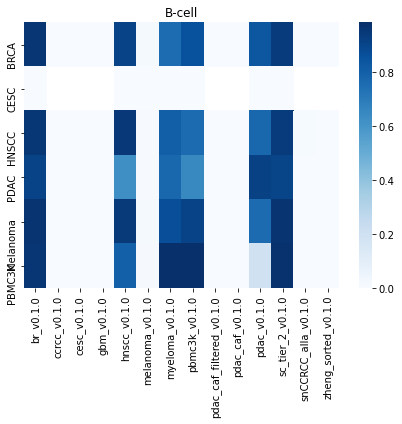

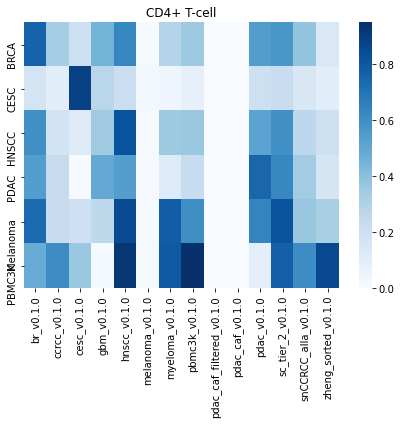

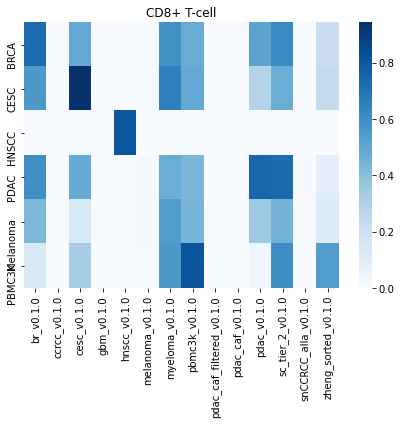

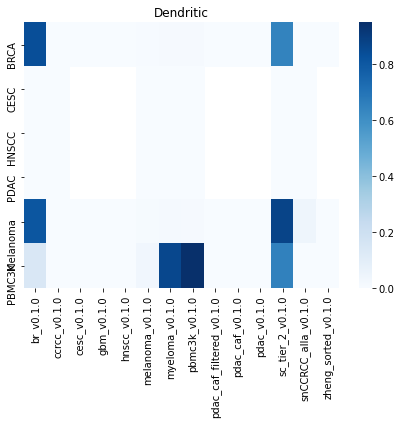

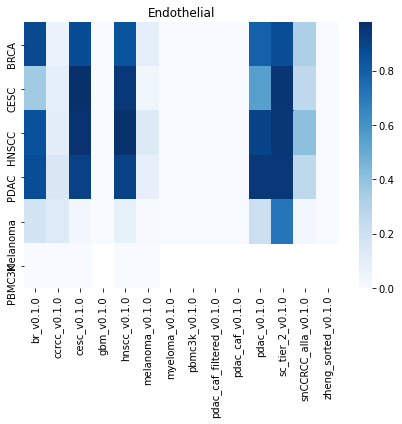

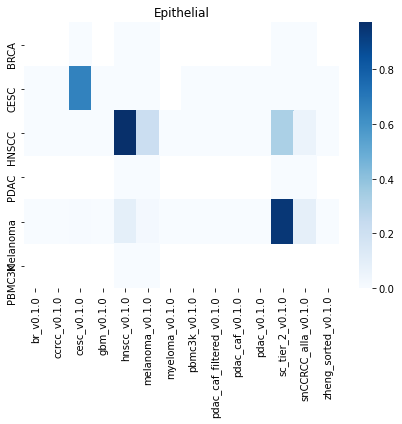

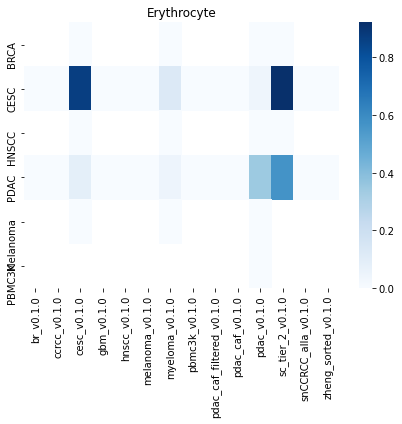

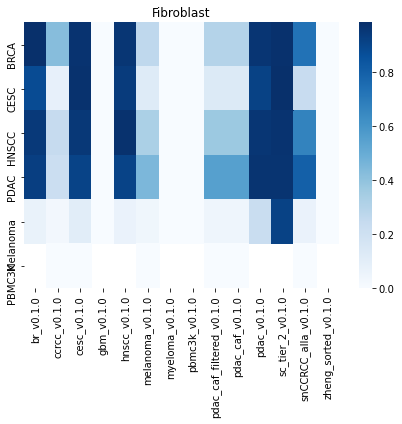

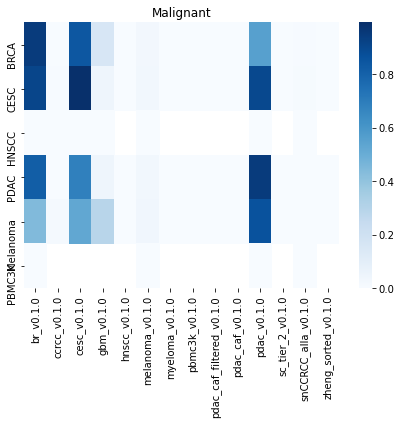

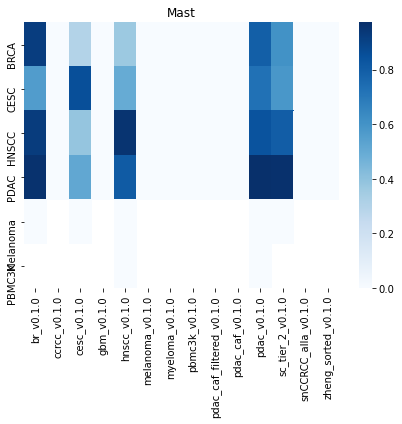

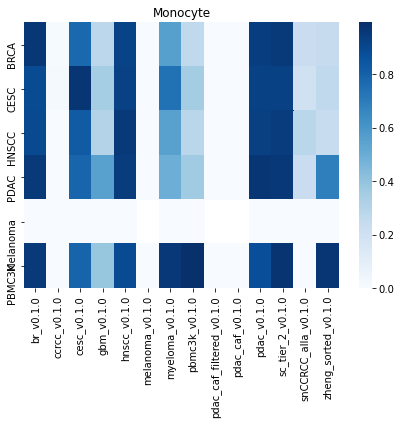

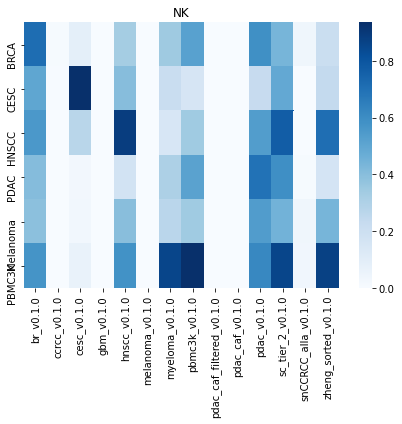

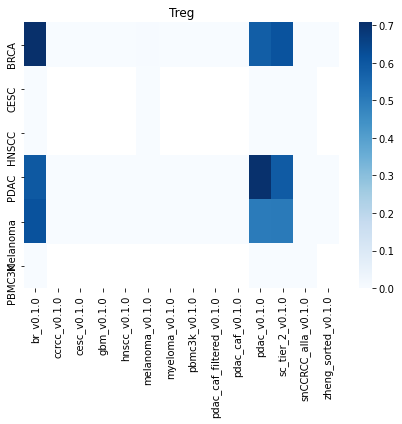

In [77]:
for cell_type, df in cell_type_to_performance.items():
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(df, cmap='Blues', ax=ax)
    plt.title(cell_type)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'cell_type_{cell_type}_performance.pdf'))
    plt.show()

In [71]:
modules = sorted(cancer_to_module_to_report['BRCA'].keys())
cell_types = sorted(set(cell_type_map.values()))
cancer_to_performance = {}
for cancer, d in cancer_to_module_to_report.items():
    
    data, idxs, cols = [], [], []
#     for cancer, d in cancer_to_module_to_report.items():
    for cell_type in cell_types:
        idxs.append(cell_type)
        line = []
        for m in modules:
            report = d[m]
            if m not in cols: cols.append(m)
#             print(report[cell_type]['f1-score'].keys())
            value = report.get(cell_type)
#             print(value)
            value = report[cell_type].get('f1-score', np.nan) if value is not None else np.nan
            line.append(value)
        data.append(line)
    df = pd.DataFrame(data=data, index=idxs, columns=cols)
    cancer_to_performance[cancer] = df

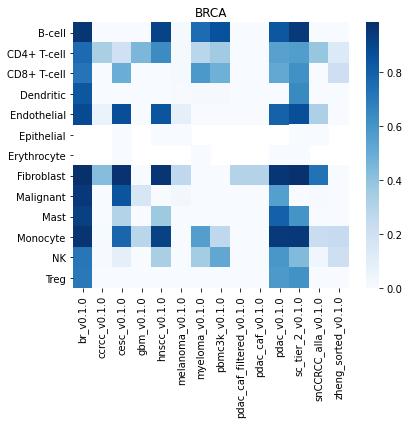

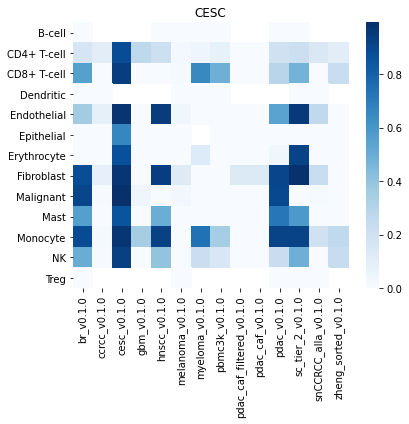

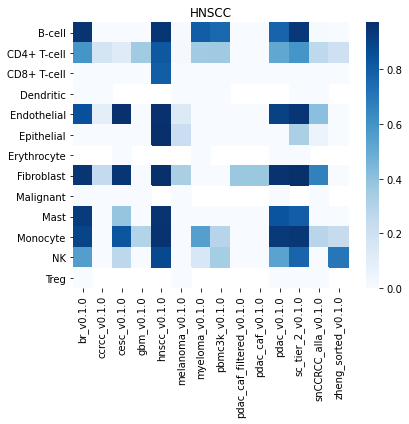

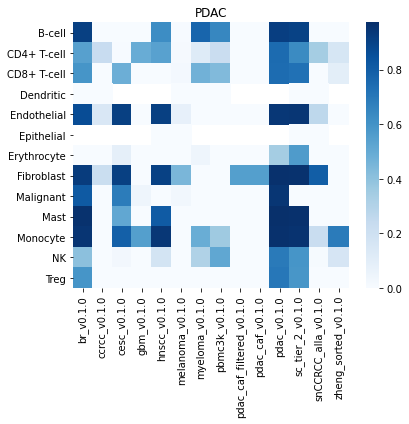

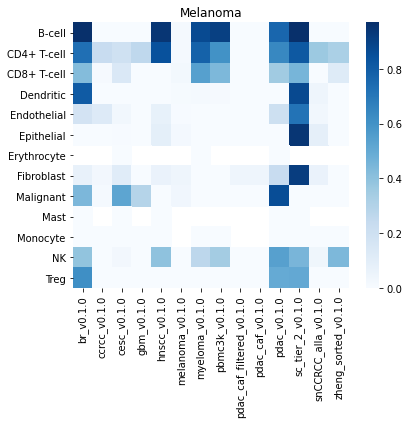

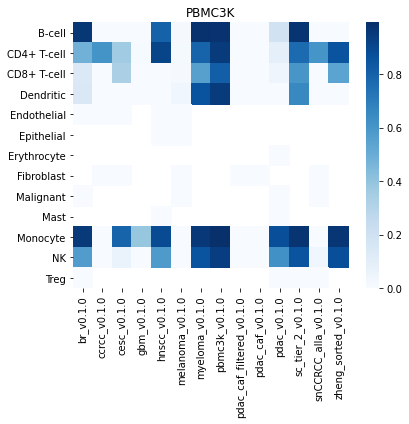

In [110]:
for cancer, df in cancer_to_performance.items():
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(df, cmap='Blues', ax=ax)
    plt.title(cancer)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'dataset_{cancer}_performance.pdf'))
    plt.show()

In [80]:
## save reports
import json
json.dump(cancer_to_module_to_report,
          open(os.path.join(results_dir, 'classification_reports.json'), 'w'))

In [130]:
def plot_model_differences(adata, pred, save=None):
    ## token examples
    adata.obs = pd.merge(adata.obs, pred, right_index=True, left_index=True)

    mask = [True if c1 in cell_type_map and c2 in cell_type_map else False
            for c1, c2 in zip(adata.obs['cell_type'], adata.obs['predicted_cell_type'])]
    adata = adata[mask].copy()

    adata.obs['cell_type'], adata.obs['predicted_cell_type'] = ([cell_type_map[c] for c in adata.obs['cell_type']],
              [cell_type_map[c] for c in adata.obs['predicted_cell_type']])
    
#     both = sorted(set(adata.obs['cell_type']).intersection(set(adata.obs['predicted_cell_type'])))
#     color_map = {o:sns.color_palette('tab20')[i] for i, o in enumerate(both)}
    
    sc.pl.umap(adata, color=['cell_type', 'predicted_cell_type', 'cell_type_probability'],
               palette=sns.color_palette('tab20'),
          ncols=1, save=save)

/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'cell_type' as categorical
... storing 'predicted_cell_type' as categorical


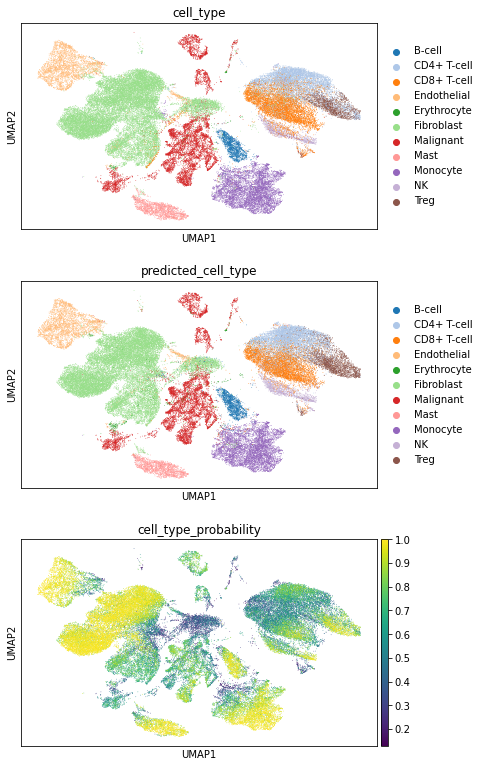

In [131]:
## token examples
adata = cancer_to_adata['PDAC'].copy()
pred = cancer_to_module_predictions['PDAC']['pdac_v0.1.0']
plot_model_differences(adata, pred, save='_pdac_pdac.pdf')


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'cell_type' as categorical
... storing 'predicted_cell_type' as categorical


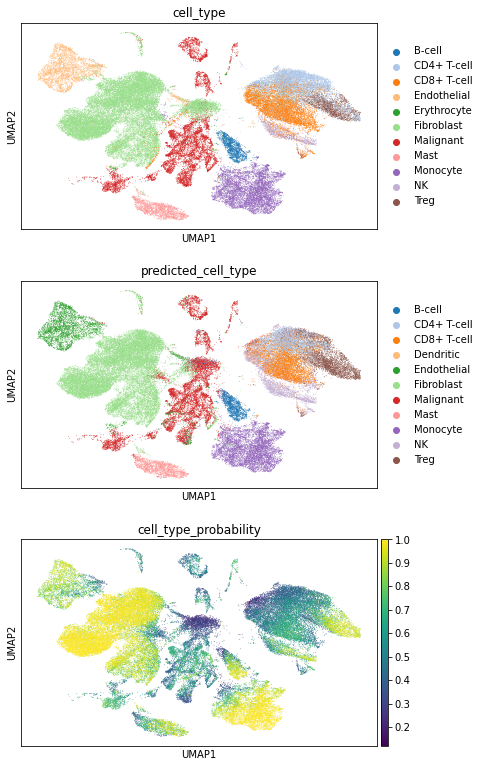

In [132]:
## token examples
adata = cancer_to_adata['PDAC'].copy()
pred = cancer_to_module_predictions['PDAC']['br_v0.1.0']
plot_model_differences(adata, pred, save='_pdac_brca.pdf')


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'cell_type' as categorical
... storing 'predicted_cell_type' as categorical


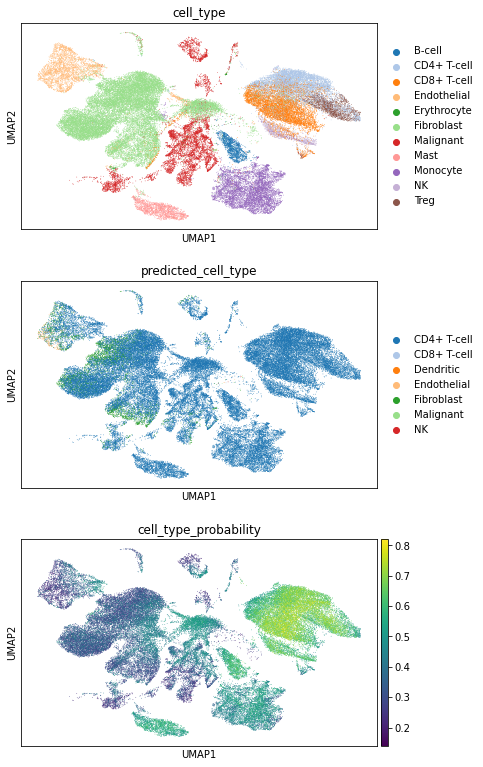

In [133]:
## token examples
adata = cancer_to_adata['PDAC'].copy()
pred = cancer_to_module_predictions['PDAC']['ccrcc_v0.1.0']
plot_model_differences(adata, pred, save='_pdac_snccrcc.pdf')


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'cell_type' as categorical
... storing 'predicted_cell_type' as categorical


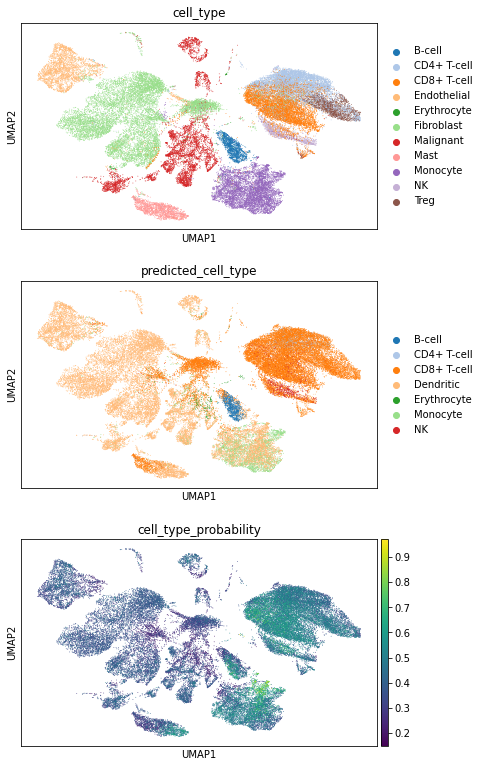

In [134]:
## token examples
adata = cancer_to_adata['PDAC'].copy()
pred = cancer_to_module_predictions['PDAC']['myeloma_v0.1.0']
plot_model_differences(adata, pred, save='_pdac_mmy.pdf')


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'cell_type' as categorical
... storing 'predicted_cell_type' as categorical


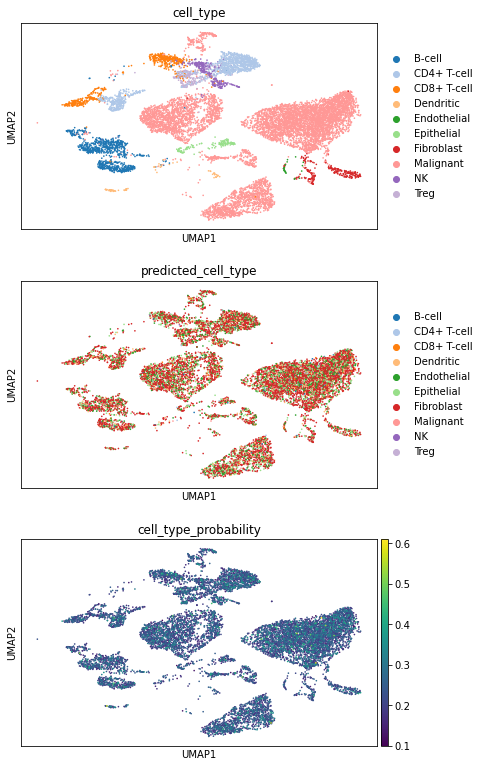

In [137]:
## token examples
adata = cancer_to_adata['Melanoma'].copy()
pred = cancer_to_module_predictions['Melanoma']['melanoma_v0.1.0']
plot_model_differences(adata, pred, save='_melanoma_melanoma.pdf')


In [136]:
list(adata.uns.keys())

['log1p', 'hvg', 'pca', 'neighbors', 'umap']

In [85]:
list(adata.obs.columns)

['orig.ident',
 'nCount_RNA',
 'nFeature_RNA',
 'percent.mito',
 'nCount_SCT',
 'nFeature_SCT',
 'SCT_snn_res.0.5',
 'seurat_clusters',
 'cell_type',
 'sample',
 'treatment',
 'ident',
 'n_genes_by_counts',
 'total_counts',
 'total_counts_mt',
 'pct_counts_mt',
 'predicted_cell_type',
 'cell_type_probability',
 'probability_Acinar',
 'probability_B',
 'probability_CD4_T',
 'probability_CD8_T',
 'probability_Ductal',
 'probability_Endothelial',
 'probability_Erythrocyte',
 'probability_Fibroblast',
 'probability_Macrophage',
 'probability_Mast',
 'probability_NK',
 'probability_Plasma',
 'probability_Tnaive',
 'probability_Treg',
 'probability_Tuft']

In [36]:
adata, module = (sc.read_h5ad('/home/estorrs/data/single_cell_classification/tumor/BR/raw/houxiang_brca/merged.h5ad'),
                '/home/estorrs/pollock/models/modules/br_v0.1.0')
# adata = predict_adata(adata, module)
adata

AnnData object with n_obs × n_vars = 48280 × 33538
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

In [37]:
adata

AnnData object with n_obs × n_vars = 48280 × 33538
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

In [38]:
adata.obs

,sample_id,cancer_type,tissue_type,organ_type,cell_type,species,method,facs
HT062B1_S1PA_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD8+ T-cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCAGTGCTCCGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Endothelial cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCATCGGAATTC-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAACAGCTAACT-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAAGTAGGGAGG-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD4+ T-cells,Homo sapiens,sc,yes
...,...,...,...,...,...,...,...,...
HT110B1_XB3_TTTCATGTCGGCAGTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT110B1_XB3_TTTCCTCGTGTTACTG-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT110B1_XB3_TTTGACTCAGGGTCTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT110B1_XB3_TTTGGAGCAAGAGGCT-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Macrophages,Homo sapiens,sc,yes


In [39]:
adata.var

""
Genes
MIR1302-2HG
FAM138A
OR4F5
AL627309.1
AL627309.3
...
AC233755.2
AC233755.1
AC240274.1
